In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-storm-impact-on-earths-power-grids/solar_storm_impact_dataset.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("/kaggle/input/solar-storm-impact-on-earths-power-grids/solar_storm_impact_dataset.csv")

# Encode categorical feature
le = LabelEncoder()
df["solar_flare_class"] = le.fit_transform(df["solar_flare_class"])

# Features & Target
X = df.drop("power_grid_disruption", axis=1)
y = df["power_grid_disruption"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(["event_id", "event_date"], axis=1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[76  4  0]
 [ 5 84  5]
 [ 0  1 25]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.94      0.89      0.92        94
           2       0.83      0.96      0.89        26

    accuracy                           0.93       200
   macro avg       0.91      0.94      0.92       200
weighted avg       0.93      0.93      0.93       200



In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


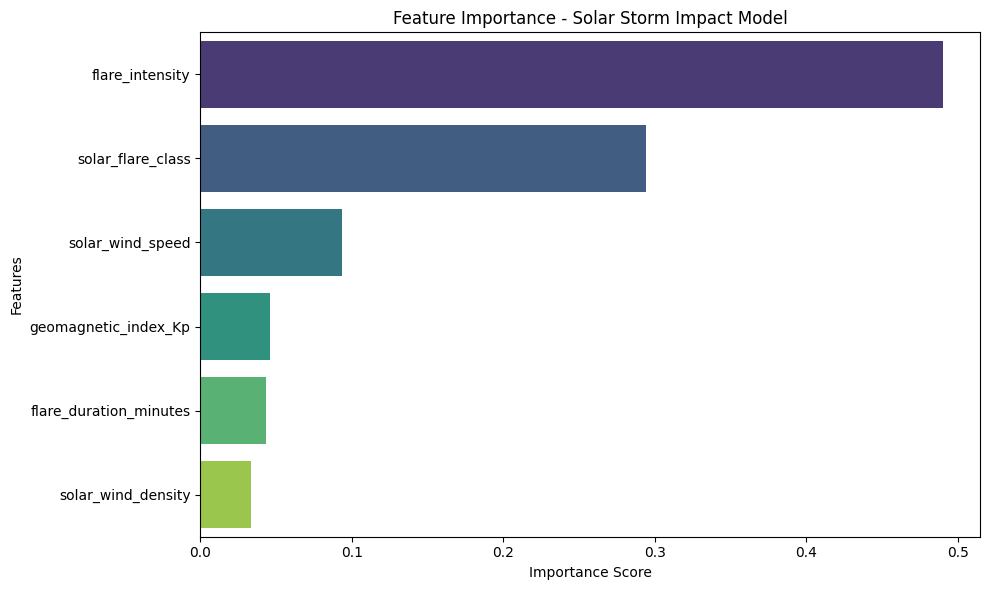

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
feature_names = X.drop(["event_id", "event_date"], axis=1).columns

# Sort features
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
plt.title("Feature Importance - Solar Storm Impact Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


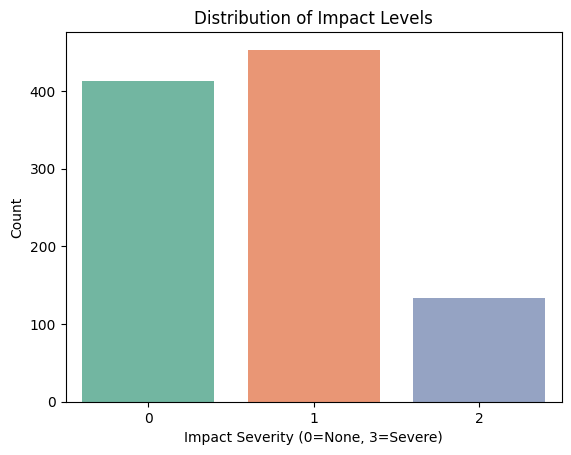

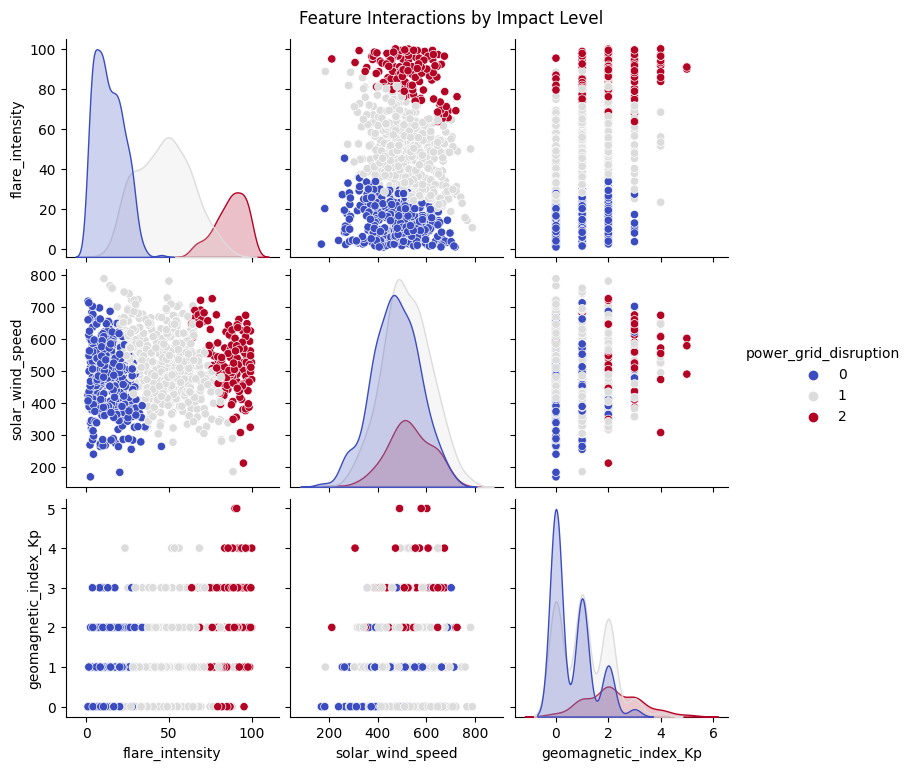

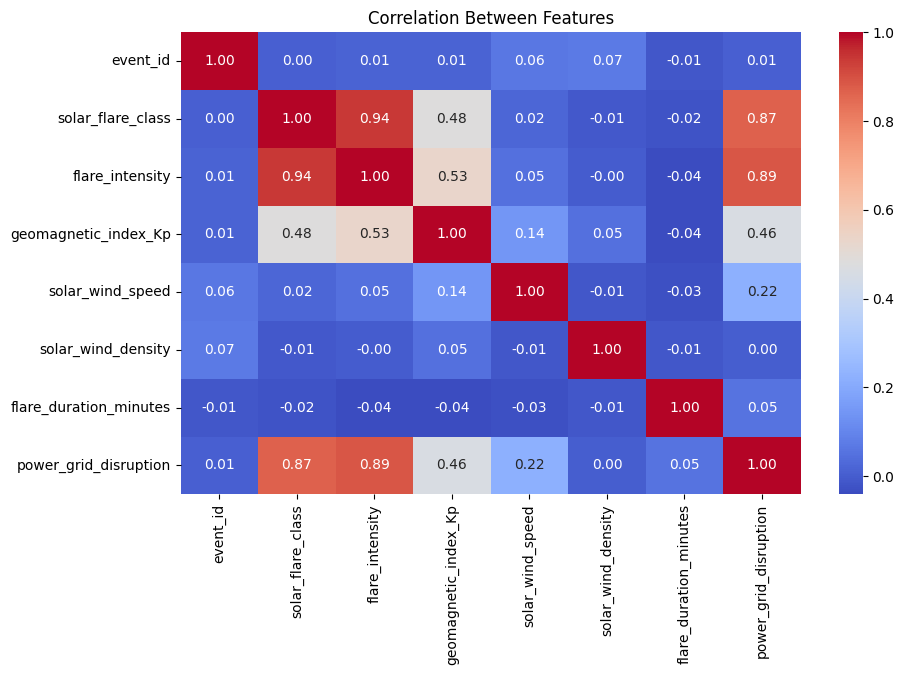

In [5]:
sns.countplot(x='power_grid_disruption', data=df, palette='Set2')
plt.title("Distribution of Impact Levels")
plt.xlabel("Impact Severity (0=None, 3=Severe)")
plt.ylabel("Count")
plt.show()

sns.pairplot(df, vars=["flare_intensity", "solar_wind_speed", "geomagnetic_index_Kp"],
             hue="power_grid_disruption", palette="coolwarm")
plt.suptitle("Feature Interactions by Impact Level", y=1.02)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Features")
plt.show()


📊 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        80
           1       0.93      0.91      0.92        94
           2       0.89      0.96      0.93        26

    accuracy                           0.93       200
   macro avg       0.92      0.94      0.93       200
weighted avg       0.93      0.93      0.93       200



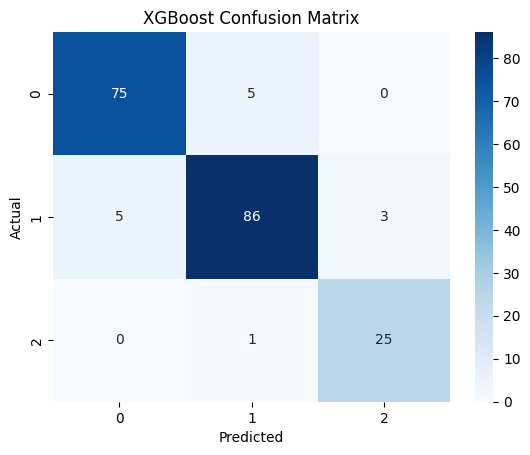

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict & Evaluate
y_pred_xgb = xgb.predict(X_test)

print("📊 XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


📊 SVM Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        80
           1       0.91      0.87      0.89        94
           2       0.75      0.81      0.78        26

    accuracy                           0.90       200
   macro avg       0.87      0.88      0.87       200
weighted avg       0.90      0.90      0.90       200



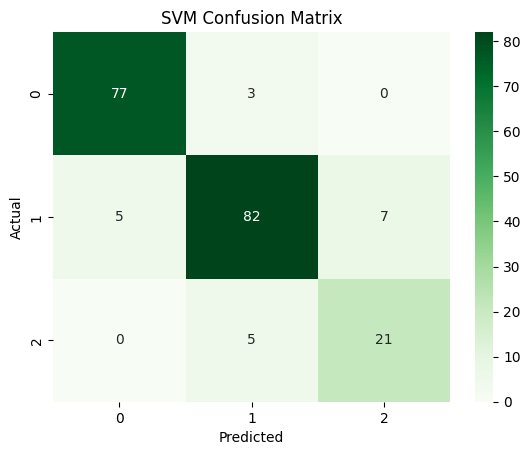

In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred_svm = svm.predict(X_test_scaled)

print("📊 SVM Classification Report")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Greens")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


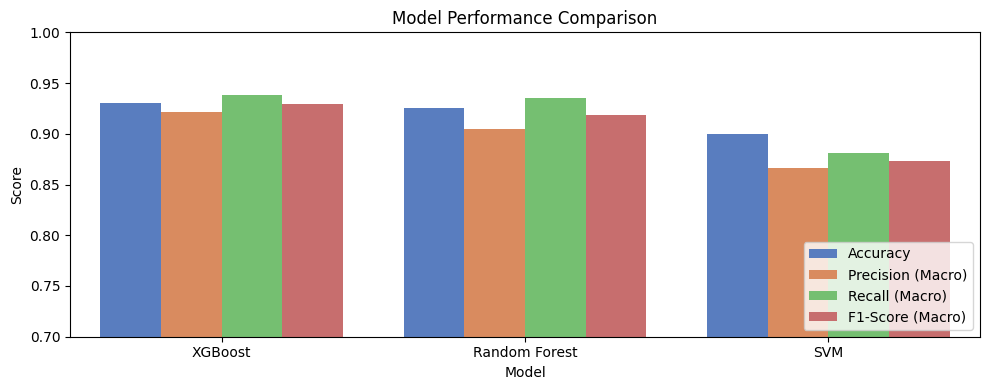

📋 Leaderboard:


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,XGBoost,0.930,0.9217,0.9380,0.9294
1,Random Forest,0.925,0.9051,0.9351,0.9183
2,SVM,0.900,0.8667,0.8808,0.8732


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred, results=[]):
    results.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'Precision (Macro)': round(precision_score(y_true, y_pred, average='macro'), 4),
        'Recall (Macro)': round(recall_score(y_true, y_pred, average='macro'), 4),
        'F1-Score (Macro)': round(f1_score(y_true, y_pred, average='macro'), 4)
    })
    return results

results = []

# Random Forest (already trained and predicted as y_pred_rf)
results = evaluate_model("Random Forest", y_test, y_pred, results)

# XGBoost (already predicted as y_pred_xgb)
results = evaluate_model("XGBoost", y_test, y_pred_xgb, results)

# SVM (already predicted as y_pred_svm)
results = evaluate_model("SVM", y_test, y_pred_svm, results)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score (Macro)", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# Display nicely
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable", palette="muted")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Also print table
print("📋 Leaderboard:")
display(results_df)
